In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import glob, os

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics

In [4]:
def read_Xy(seed, n_vars):
    # Find the folder name organized by seed number
    seed_docs = sorted(glob.glob('../../datas/seed_*/'))
    
    # Store different seeds
    Xtrains = []
    Xvalids = []
    Xtests  = []
    ytrains = []
    yvalids = []
    ytests  = []
    sizes = []
    # Load the data
    for ind,obj in enumerate(seed_docs):
        # Load the y data
        ytrain = {'max': pd.read_csv(obj + 'y_train_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
                  'cdf': pd.read_csv(obj + 'y_train_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}
        yvalid = {'max': pd.read_csv(obj + 'y_validation_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
                  'cdf': pd.read_csv(obj + 'y_validation_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}
        ytest  = {'max': pd.read_csv(obj + 'y_test_max.csv', header=None).iloc[1:,:].reset_index().drop(columns='index'), 
                  'cdf': pd.read_csv(obj + 'y_test_cdf.csv', header=None).iloc[1:,:].reset_index().drop(columns='index')}
        
        # Load the x data
        X_nonorml_train = baseline.load_pickle(f'../../datas/proc/part2/X/{seed}/' + f'X_train_{n_vars}.pkl')['X'][ind]
        X_nonorml_valid = baseline.load_pickle(f'../../datas/proc/part2/X/{seed}/' + f'X_valid_{n_vars}.pkl')['X'][ind]
        X_nonorml_test  = baseline.load_pickle(f'../../datas/proc/part2/X/{seed}/' + f'X_test_{n_vars}.pkl')['X'][ind]
    
        # Load the size data
        sizes.append(baseline.load_pickle(f'../../datas/proc/part2/X/{seed}/' + f'X_train_{n_vars}.pkl')['varsize'][ind])

        # Normalize the data
        scaler = StandardScaler().fit(X_nonorml_train)
        Xtrain = scaler.transform(X_nonorml_train)
        Xvalid = scaler.transform(X_nonorml_valid)
        Xtest  = scaler.transform(X_nonorml_test)

        # Store the data
        Xtrains.append(Xtrain)
        Xvalids.append(Xvalid)
        Xtests.append(Xtest)
        ytrains.append(ytrain)
        yvalids.append(yvalid)
        ytests.append(ytest)
        
    return {'Xtrains': Xtrains, 'Xvalids': Xvalids, 'Xtests': Xtests, 'ytrains': ytrains, 'yvalids': yvalids, 'ytests': ytests, 'sizes': sizes}

In [100]:
from natsort import natsorted
def r2_score_f(y_true,y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    r2 = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
    return r2


In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def get_r2valid_and_complexity(n_vars,seed_varcv):
    # Read the data
    data = read_Xy(seed_varcv, n_vars)
    
    # Read trained models
    model_list = natsorted(glob.glob(f'../../datas/proc/part2/nestedMLR/{seed_varcv}/cv_*_var_{n_vars}_bestmodel.pkl'))
    
    # Load the trained models
    models = [baseline.load_pickle(model) for model in model_list]

    r2_valids, r2_trains, r2_tests, sizes_valids, phy_size_valids = [],[],[],[],[]
    ydicts = []
    for i in range(10):
        ydict = {}
        r2_valids.append(r2_score_f(data['yvalids'][i]['cdf'].values,models[i]['bestmodel'].predict(data['Xvalids'][i])))
        ydict['yvalid_pred'] = models[i]['bestmodel'].predict(data['Xvalids'][i])
        ydict['yvalid_true'] = data['yvalids'][i]['cdf'].values

        r2_trains.append(r2_score_f(data['ytrains'][i]['cdf'].values,models[i]['bestmodel'].predict(data['Xtrains'][i])))
        ydict['ytrain_pred'] = models[i]['bestmodel'].predict(data['Xtrains'][i])
        ydict['ytrain_true'] = data['ytrains'][i]['cdf'].values

        r2_tests.append(r2_score_f(data['ytests'][i]['cdf'].values,models[i]['bestmodel'].predict(data['Xtests'][i])))
        ydict['ytest_pred'] = models[i]['bestmodel'].predict(data['Xtests'][i])
        ydict['ytest_true'] = data['ytests'][i]['cdf'].values

        sizes_valids.append(np.sum(np.asarray(data['sizes'][i])))
        phy_size_valids.append(n_vars)
        ydicts.append(ydict)


    return r2_trains, r2_valids, r2_tests, sizes_valids,phy_size_valids, ydicts

In [102]:
# Model complexity
n_vars = 5

# Seed number for correlation variable cross-validation
seed_varcv = 1

store_results = {}
for n_vars in [2, 3, 4, 5]:
    store_results[f'{n_vars}'] = get_r2valid_and_complexity(n_vars,seed_varcv)

In [90]:
store_results['2'][-1][0]['yvalid_pred'][0:2,:]

array([[2.36765548, 1.47359734, 1.38052109, 2.9806981 , 1.10028576,
        0.714757  , 4.09540764, 0.91101658, 0.71828595, 0.56929634,
        1.17322355, 2.21198133, 2.2212163 , 0.59224292, 1.26314574],
       [2.61720542, 1.64392923, 1.32362151, 2.96243182, 1.36814831,
        0.68988871, 4.57517471, 1.04139874, 0.68371999, 0.45778277,
        1.30366026, 2.37372183, 2.23274063, 0.6919006 , 1.05514512]])

In [92]:
store_results['2'][-1][0]['yvalid_pred'][0:2,:].flatten()

array([2.36765548, 1.47359734, 1.38052109, 2.9806981 , 1.10028576,
       0.714757  , 4.09540764, 0.91101658, 0.71828595, 0.56929634,
       1.17322355, 2.21198133, 2.2212163 , 0.59224292, 1.26314574,
       2.61720542, 1.64392923, 1.32362151, 2.96243182, 1.36814831,
       0.68988871, 4.57517471, 1.04139874, 0.68371999, 0.45778277,
       1.30366026, 2.37372183, 2.23274063, 0.6919006 , 1.05514512])

In [94]:
store_results['2'][-1][0]['yvalid_true'][0:2,:].flatten()

array([0.43416257, 0.09629943, 2.53327514, 0.21070896, 0.07750736,
       0.08138084, 1.86250996, 0.07957025, 0.17156206, 0.0311104 ,
       0.75805894, 1.67338676, 2.65324704, 0.0834221 , 0.0390813 ,
       2.83267521, 2.82178632, 0.67042071, 4.06922139, 1.21347463,
       0.28077558, 3.75805739, 0.91023414, 0.26891327, 0.06098095,
       0.66373998, 1.46091615, 0.48655505, 0.36195404, 0.50447758])

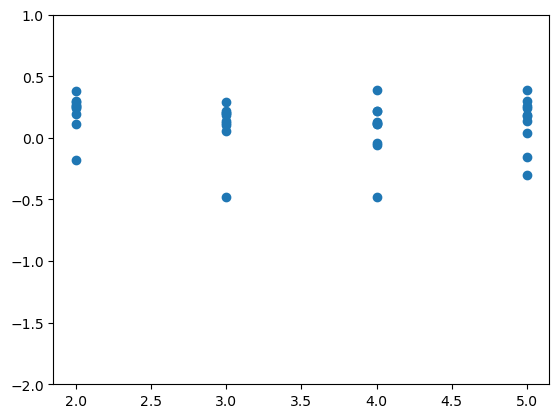

In [103]:
for n_vars in [2, 3, 4, 5]:
    r2_trains, r2_valids, r2_tests, sizes_valids, phy_size_valids, _ = store_results[f'{n_vars}']
    plt.scatter((phy_size_valids), (r2_valids), c='tab:blue')
    plt.ylim(-2,1)